<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [7]:
sentences = []
word_threshold = 32

for sentence in dataset["train"]["text"]:
  sentences.extend([i.lower() for i in nltk.sent_tokenize(sentence) if len(nltk.word_tokenize(i)) < word_threshold])

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 198801


Посчитаем для каждого слова его встречаемость.

In [9]:
words = Counter()

for sentence in sentences:
  for word in nltk.word_tokenize(sentence):
    words[word] += 1

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
vocab = set()
vocab.add('<unk>')
vocab.add('<bos>')
vocab.add('<eos>')
vocab.add('<pad>')
vocab_size = 40000

i = 0
for word, count in sorted(words.items(), key = lambda x: x[1], reverse=True):
  if i >= vocab_size:
    break
  vocab.add(word)
  i += 1
print(i)

40000


In [11]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [12]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [13]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [21]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        tokenized_sentence += [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [22]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [23]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 64

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [24]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            logits = model(batch["input_ids"]).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())


    perplexity = sum(perplexity) / len(perplexity)
    print(f"Perplexity: {perplexity}")

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [25]:
def train_model(model, epoch):
  model.train()
  epoch_loss = 0
  for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
    x, targets = batch["input_ids"].to(device), batch["target_ids"].to(device)
    optimizer.zero_grad()
    preds = model(x).flatten(start_dim=0, end_dim=1)
    loss = criterion(preds, targets.flatten())
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  print(f"Loss: {epoch_loss / len(train_dataloader)}")
  return epoch_loss / len(train_dataloader)


Базовая модель:

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.activation = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embeddings = self.embeddings(x)
        out, _ = self.rnn(embeddings)
        out = self.activation(out)
        out = self.projection(out)

        return out

In [ ]:
base_model = BaseModel(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.SGD(base_model.parameters(), lr=1e-4)

epochs = 5
losses = []
perplexities = []
for epoch in range(1, epochs + 1):
  losses.append(train_model(base_model, epoch))
  perplexities.append(evaluate(base_model, criterion, eval_dataloader))


Training epoch 1::   0%|          | 0/2485 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/2485 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/2485 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/2485 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/2485 [00:00<?, ?it/s]

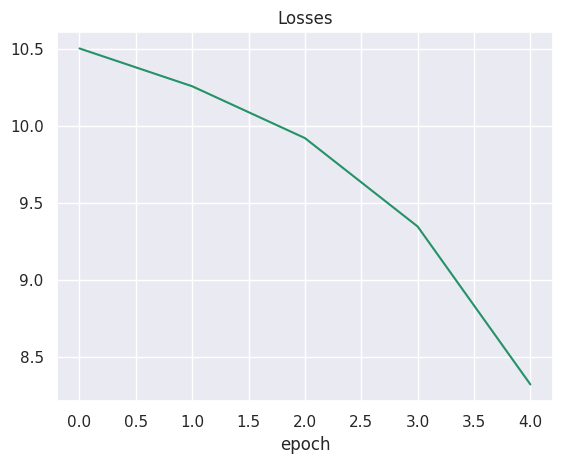

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

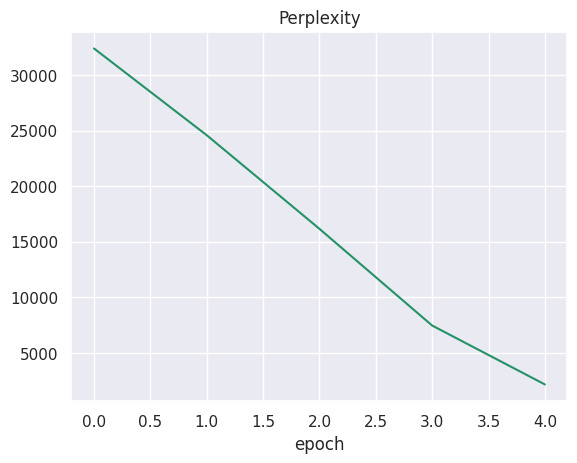

In [ ]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
print(f"Perplexities: {evaluate(base_model, criterion, test_dataloader)}")

Perplexities: 2155.59791883855


### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [26]:
class LanguageModel(nn.Module):
  def __init__(self, hidden_dim, vocab_size):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, hidden_dim)
    self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
    self.linnear = nn.Linear(hidden_dim, hidden_dim)
    self.projection = nn.Linear(hidden_dim, vocab_size)

    self.activation = nn.Tanh()
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    embeddings = self.embeddings(x)
    out, _ = self.rnn(embeddings)
    out = self.dropout(out)
    out = self.activation(out)
    out = self.linnear(out)
    out = self.activation(out)
    out = self.dropout(out)
    out = self.projection(out)

    return out

In [27]:
model = LanguageModel(300, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5
losses = []
perplexities = []
for epoch in range(1, epochs + 1):
  losses.append(train_model(model, epoch))
  perplexities.append(evaluate(model, criterion, eval_dataloader))

Training epoch 1::   0%|          | 0/2485 [00:00<?, ?it/s]

Loss: 5.43712349705533


  0%|          | 0/311 [00:00<?, ?it/s]

Perplexity: 146.12761489524718


Training epoch 2::   0%|          | 0/2485 [00:00<?, ?it/s]

Loss: 5.027846285323022


  0%|          | 0/311 [00:00<?, ?it/s]

Perplexity: 125.02816058585115


Training epoch 3::   0%|          | 0/2485 [00:00<?, ?it/s]

Loss: 4.897853737146082


  0%|          | 0/311 [00:00<?, ?it/s]

Perplexity: 116.38608467617219


Training epoch 4::   0%|          | 0/2485 [00:00<?, ?it/s]

Loss: 4.81636274345444


  0%|          | 0/311 [00:00<?, ?it/s]

Perplexity: 111.55132413907066


Training epoch 5::   0%|          | 0/2485 [00:00<?, ?it/s]

Loss: 4.7573580728450295


  0%|          | 0/311 [00:00<?, ?it/s]

Perplexity: 108.34605145224421


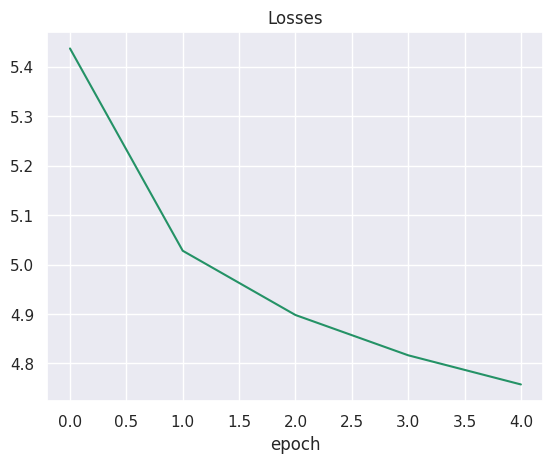

In [28]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

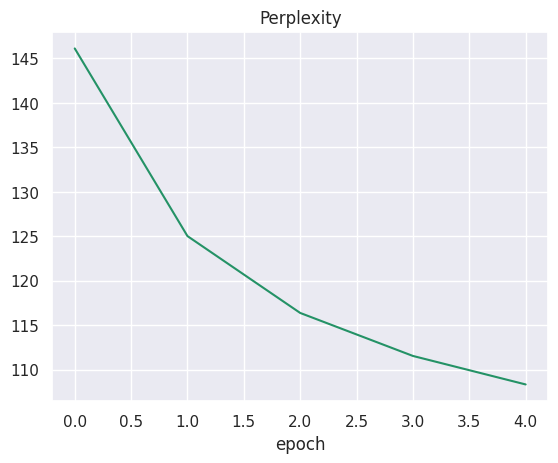

In [29]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [30]:
print(f"Perplexities: {evaluate(model, criterion, test_dataloader)}")

  0%|          | 0/311 [00:00<?, ?it/s]

Perplexity: 106.51929805056459
Perplexities: 106.51929805056459


In [ ]:
torch.save(model, "model1")

In [31]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in starting_seq.split()]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break

    sentence = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return sentence

In [32]:
generate_sequence(model, starting_seq = "good movie")

"<bos> good movie , but it 's not a good movie . <eos>"

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [33]:
class LanguageModel(nn.Module):
  def __init__(self, hidden_dim, vocab_size):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, hidden_dim)
    self.rnn1 = nn.LSTM(hidden_dim, hidden_dim, num_layers=3, batch_first=True, dropout=0.25)
    self.linnear = nn.Linear(hidden_dim, 2 * hidden_dim)
    self.projection = nn.Linear(2 * hidden_dim, vocab_size)

    self.activation = nn.Tanh()
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    embeddings = self.embeddings(x)
    out, _ = self.rnn1(embeddings)
    out = self.dropout(out)
    out = self.activation(out)
    out = self.linnear(out)
    out = self.activation(out)
    out = self.dropout(out)
    out = self.projection(out)

    return out

In [34]:
model_advanced = LanguageModel(350, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_advanced.parameters(), lr=1e-3)

epochs = 5
losses = []
perplexities = []
for epoch in range(1, epochs + 1):
  losses.append(train_model(model_advanced, epoch))
  perplexities.append(evaluate(model_advanced, criterion, eval_dataloader))

Training epoch 1::   0%|          | 0/2485 [00:00<?, ?it/s]

Loss: 5.605461103143826


  0%|          | 0/311 [00:00<?, ?it/s]

Perplexity: 160.79585783734584


Training epoch 2::   0%|          | 0/2485 [00:00<?, ?it/s]

Loss: 5.059218666107362


  0%|          | 0/311 [00:00<?, ?it/s]

Perplexity: 129.70741912253033


Training epoch 3::   0%|          | 0/2485 [00:00<?, ?it/s]

Loss: 4.892802670592034


  0%|          | 0/311 [00:00<?, ?it/s]

Perplexity: 116.78258185677973


Training epoch 4::   0%|          | 0/2485 [00:00<?, ?it/s]

Loss: 4.78505270246049


  0%|          | 0/311 [00:00<?, ?it/s]

Perplexity: 109.29886754762705


Training epoch 5::   0%|          | 0/2485 [00:00<?, ?it/s]

Loss: 4.706129072177818


  0%|          | 0/311 [00:00<?, ?it/s]

Perplexity: 104.17215593834781


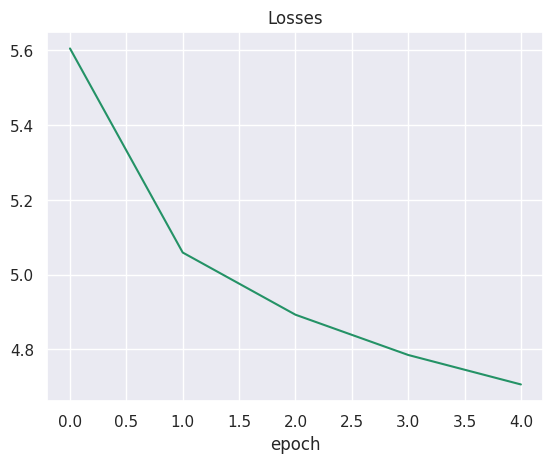

In [35]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

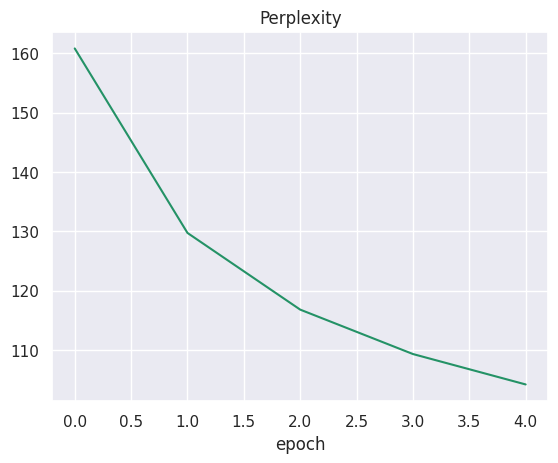

In [36]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [37]:
print(f"Perplexities: {evaluate(model_advanced, criterion, test_dataloader)}")

  0%|          | 0/311 [00:00<?, ?it/s]

Perplexity: 102.2014439082989
Perplexities: 102.2014439082989


In [43]:
generate_sequence(model_advanced, starting_seq = "movie")

'<bos> movie , and the movie is a good movie . <eos>'

In [ ]:
torch.save(model_advanced, "model2")

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Эксперименты:
- Базовая модель - результат перплексии на тестовой выборке 2155.59;

Базовая модель не смогла даже близко что-то выучить из тренировочного набора, т.к. модели не хватило параметров, а также обычный SGD требует намного больше эпох для того, чтобы сойтись к низкой ошибке. Данную модель хорошо использовать в качестве base-line модели, чтобы понять какие улучшения ведут к лучшему результату
- 1 Эксперимент - результат перплексии на тестовой выборке 4.21;

Доработанная модель уже показывает неплохую обобщающую способность благодаря тому, что был использован LSTM слой, а не ванильный RNN, а также дополнительный линейный слой после рекуррентного. Благодаря всему этому модели хватило общего количества параметров, чтобы сойтись на небольшой ошибке. Дополнительно с этим продвинутый оптимизатор в виде Adam позволил уже к 5 эпохе получить небольшую ошибку, а слои dropout между всеми слоями добавил стабильности модели
- 2 Эксперимент -  результат перплексии на тестовой выборке 3.45;

Добавление нескольких блоков в рекуррентном слое LSTM и увеличение линейного слоя вместе с увеличения размерности эмбеддингов дает еще меньшую ошибку и не переобучается, что говорит о том, что в модель можно еще больше увеличивать для обобщающей способности. В качестве регуляризации был добавлен слой dropout внутри блоков LSTM слоя для большей стабильности модели


В качестве дальнейших улучшений нужно безусловно увеличить количество эпох и дойти до момента, когда модель не сможет обощать тренировочные данные и начнет переобучаться. Также стоит попробовать увеличить глубину линейных слоев с добавлением хотя бы одного слоя батч-нормализации

In [ ]:
model = LanguageModel(300, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
model1 = torch.load("/content/model1").to(device)

In [ ]:
print(f"Perplexities: {evaluate(model1, criterion, test_dataloader)}")

  0%|          | 0/311 [00:00<?, ?it/s]

Perplexity: 191280856837235.25
Perplexities: 191280856837235.25
